In [379]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn import metrics
import numpy as np

random.seed(1)

df = pd.read_csv('Datasets_Zrive/feature_frame.csv')

### Data Transformation

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [381]:
print(len(df.vendor.value_counts()))
print(len(df.product_type.value_counts()))

264
62


In [382]:
#FREQUENCY ENCODING

vendor_value_counts = df.vendor.value_counts()
product_type_counts = df.product_type.value_counts()

df['vendor'] = df['vendor'].apply(lambda x: vendor_value_counts[x]).astype('int32')
df['product_type'] = df['product_type'].apply(lambda x: product_type_counts[x]).astype('int32')


In [383]:
#Changing Data Types

df = df.drop(['created_at'], axis=1)
df['outcome'] = df['outcome'].astype('int8')
df['order_date'] = pd.to_datetime(df['order_date'])
conversion_factor = 1e-9
df['order_date'] = df['order_date'].astype('int64').astype('float64') * conversion_factor



In [384]:
#Reordering columns
new_order = df.columns.to_list()
new_order.remove('outcome')
new_order.remove('product_type')
new_order = ['outcome'] + new_order[:3] + ['product_type'] + new_order[3:]
df = df[new_order]
df.head()

,outcome,variant_id,order_id,user_id,product_type,order_date,user_order_seq,ordered_before,abandoned_before,active_snoozed,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,0,33826472919172,2807985930372,3482464092292,128098,1.601856e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,0,33826472919172,2808027644036,3466586718340,128098,1.601856e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,0,33826472919172,2808099078276,3481384026244,128098,1.601856e+09,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,0,33826472919172,2808393957508,3291363377284,128098,1.601942e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,0,33826472919172,2808429314180,3537167515780,128098,1.601942e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [385]:
#Filtering for transactions with more than 5 items sold
df_orders = df.groupby(by='order_id')['outcome'].sum()
print(len(df_orders))
transac_5_items = df_orders[df_orders>5].index.to_list()

3446


In [386]:
#Splitting for test/train/validation, keeping the transactions in the same dataset to avoid data leakeage

random.shuffle(transac_5_items)

train_data_orders =  transac_5_items[:int(len(transac_5_items)*0.7)]
val_data_orders = transac_5_items[int(len(transac_5_items)*0.7):int(len(transac_5_items)*0.9)]
test_data_orders = transac_5_items[int(len(transac_5_items)*0.9):]

### Main Models

In [387]:
train_data_x = df[df['order_id'].isin(train_data_orders)].iloc[:,4:]
train_data_y = df[df['order_id'].isin(train_data_orders)].iloc[:,0]
val_data_x = df[df['order_id'].isin(val_data_orders)].iloc[:,4:]
val_data_y = df[df['order_id'].isin(val_data_orders)].iloc[:,0]
test_data_x = df[df['order_id'].isin(test_data_orders)].iloc[:,4:]
test_data_y = df[df['order_id'].isin(test_data_orders)].iloc[:,0]

In [388]:
def draw_roc_prc(real_y, y_prob, title):
    '''
    Plots a ROC and a Precision and Recall curve.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fpr, tpr, thresholds = metrics.roc_curve(real_y, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig.suptitle(f'ROC and Precision-Recall Curves: {title}')

    ax[0].set_title(f'ROC curve (AUC = {roc_auc:.2f})')
    ax[0].plot(fpr, tpr, color='darkorange', lw=2)
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')

    precision, recall, thresholds = metrics.precision_recall_curve(real_y, y_prob)

    average_precision = metrics.average_precision_score(real_y, y_prob)

    ax[1].plot(recall, precision, marker='.')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve (AUC-PR = {:.2f})'.format(average_precision))
    plt.tight_layout()
    plt.show()



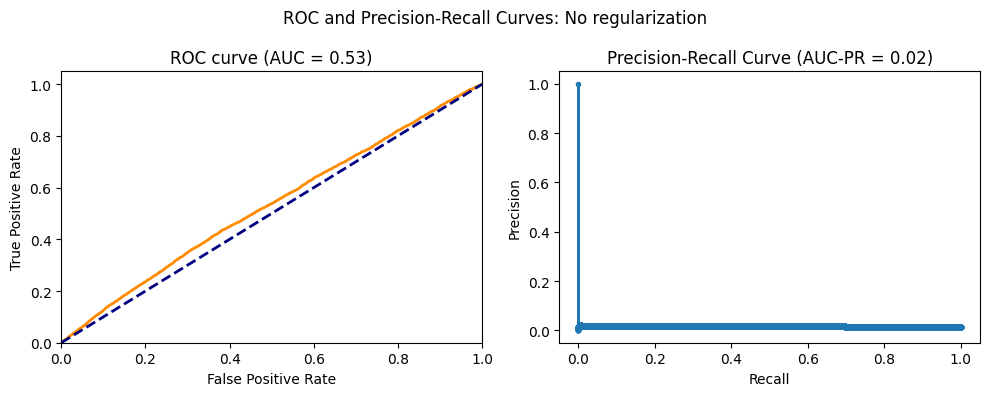

[[1394040       0]
 [  21434       0]]


In [389]:
#Base model with no penalties
log_model_base = LogisticRegression(penalty= None, n_jobs=-1, class_weight='balanced').fit(train_data_x,train_data_y)

y_train_pred_base = log_model_base.predict(train_data_x)
y_train_prob_base = log_model_base.predict_proba(train_data_x)[:,1]

draw_roc_prc(train_data_y, y_train_prob_base,"No regularization")
print(metrics.confusion_matrix(train_data_y,y_train_pred_base))


In [390]:
def best_threshold(y_true:pd.core.series.Series, y_prob:np.ndarray)->int:
    '''
    Function to obtain the threshold that minimizes false positive to be the closest possible to 1%.
    '''
    mean = y_prob.mean()
    std = y_prob.std()
    thresholds = np.arange(mean - 3*std, mean + 3*std, std/5)

    best_threshold = None

    for threshold in thresholds:

        y_pred = (y_prob >= threshold).astype(int)
        
        false_positives = metrics.confusion_matrix(y_true, y_pred)[0][1]

        if false_positives > y_true.sum()/100:
            best_threshold = threshold

    print(f"Best Threshold: {best_threshold}")

    return best_threshold

In [391]:
threshold_base = best_threshold(train_data_y, y_train_prob_base)

Best Threshold: 0.49994339123985077


{'C': 0.0001, 'penalty': 'l2'}


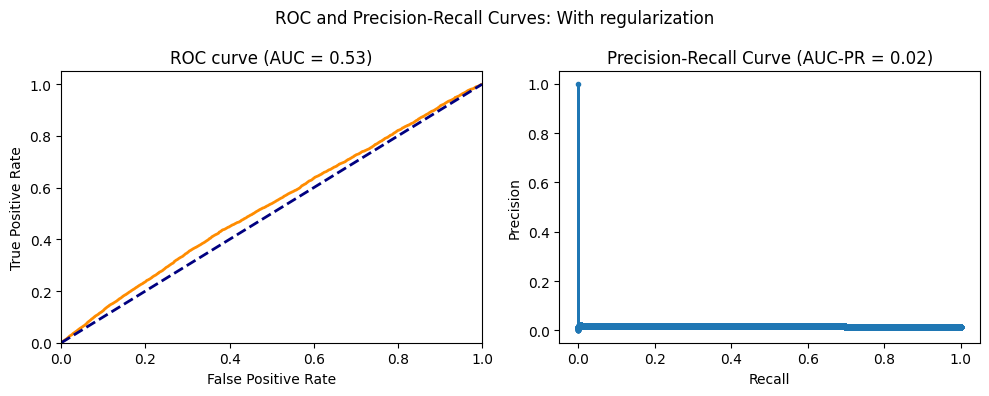

[[1394040       0]
 [  21434       0]]


In [392]:
#Model with l2 Regularization

param_grid = {
    'C': [10 ** i for i in range(-4,3)],
    'penalty': ['l2']}

log_model_reg = LogisticRegression(n_jobs=-1, class_weight='balanced')

grid_search_l2 = GridSearchCV(log_model_reg, param_grid, cv=5, scoring='accuracy',n_jobs=-1).fit(train_data_x,train_data_y)

print(grid_search_l2.best_params_)

y_train_pred_l2 = grid_search_l2.predict(train_data_x)
y_train_prob_l2 = grid_search_l2.predict_proba(train_data_x)[:,1]

draw_roc_prc(train_data_y, y_train_prob_l2,"With regularization")
print(metrics.confusion_matrix(train_data_y,y_train_pred_l2))


In [393]:
threshold_l2 = best_threshold(train_data_y, y_train_prob_l2)

Best Threshold: 0.49994339123985077


In [394]:
#New balanced dataset with 50% 0 incomes and 1 outcomes
train_data = df[df['order_id'].isin(train_data_orders)]
majority_class = train_data[train_data['outcome'] == 0]
minority_class = train_data[train_data['outcome'] == 1]

majority_class_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

balanced_df = pd.concat([majority_class_undersampled, minority_class])

balanced_df

,outcome,variant_id,order_id,user_id,product_type,order_date,user_order_seq,ordered_before,abandoned_before,active_snoozed,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
591213,0,33667282075780,2861168459908,3815052968068,31593,1.606867e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,36.0,28.786199,27.0,30.0,24.688701
1100617,0,34086450987140,2887443120260,3874925314180,51266,1.609632e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,54.0,34.910030,30.0,36.0,28.268085
2007369,0,33667185016964,2885305139332,3745761755268,54442,1.609286e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,37.0,20.293677,30.0,36.0,29.372186
2600832,0,34284953796740,2920192966788,3898440056964,45381,1.613088e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,37.5,30.297336,30.0,24.0,26.048133
1096726,0,34137389105284,2868033257604,3766058123396,114978,1.607472e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,45.0,29.815304,30.0,32.0,28.189363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860233,1,34304342851716,2827489443972,3765099954308,10120,1.603930e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,47.0,31.017468,30.0,39.0,35.641908
2860234,1,34304342851716,2827551244420,3513667223684,10120,1.603930e+09,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,47.0,31.017468,30.0,39.0,35.641908
2860261,1,34304342851716,2829221494916,3784403714180,10120,1.604102e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,47.0,31.017468,30.0,39.0,35.641908
2863549,1,33826433859716,2823601127556,3469897564292,20585,1.603411e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,82.0,44.243644,30.0,38.5,31.832738


{'C': 0.0001, 'penalty': 'l2'}


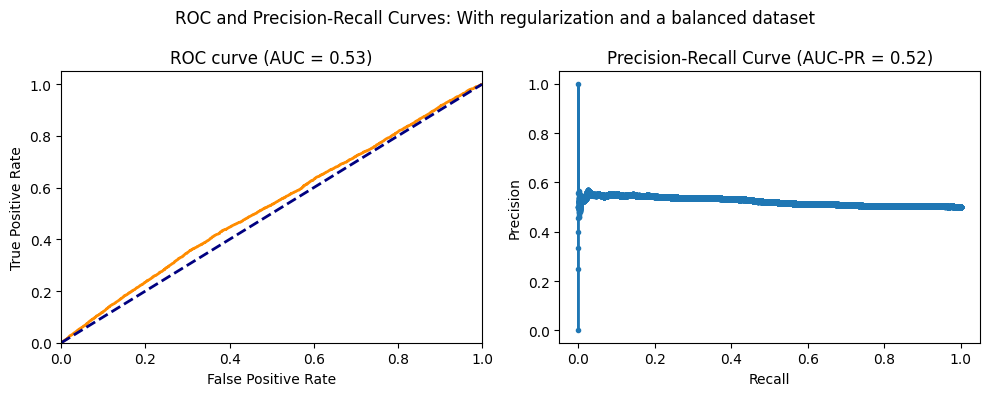

[[21434     0]
 [21434     0]]


In [395]:
balanced_train_data_x = balanced_df.iloc[:,4:]
balanced_train_data_y = balanced_df.iloc[:,0]

#Logistic regression with balanced training data

param_grid = {
    'C': [10 ** i for i in range(-4,2)],
    'penalty': ['l2']
}

log_model_balanced = LogisticRegression(solver='lbfgs',n_jobs=-1, class_weight='balanced')

grid_search_balanced = GridSearchCV(log_model_balanced, param_grid, cv=5, scoring='accuracy').fit(balanced_train_data_x,balanced_train_data_y)

print(grid_search_balanced.best_params_)

y_train_pred_balanced = grid_search_balanced.predict(balanced_train_data_x)
y_train_prob_balanced = grid_search_balanced.predict_proba(balanced_train_data_x)[:,1]

draw_roc_prc(balanced_train_data_y, y_train_prob_balanced,"With regularization and a balanced dataset")
print(metrics.confusion_matrix(balanced_train_data_y,y_train_pred_balanced))



In [396]:
threshold_balanced = best_threshold(balanced_train_data_y, y_train_prob_balanced)

Best Threshold: 0.4999481480929332


LogisticRegression(C=0.001, class_weight='balanced')


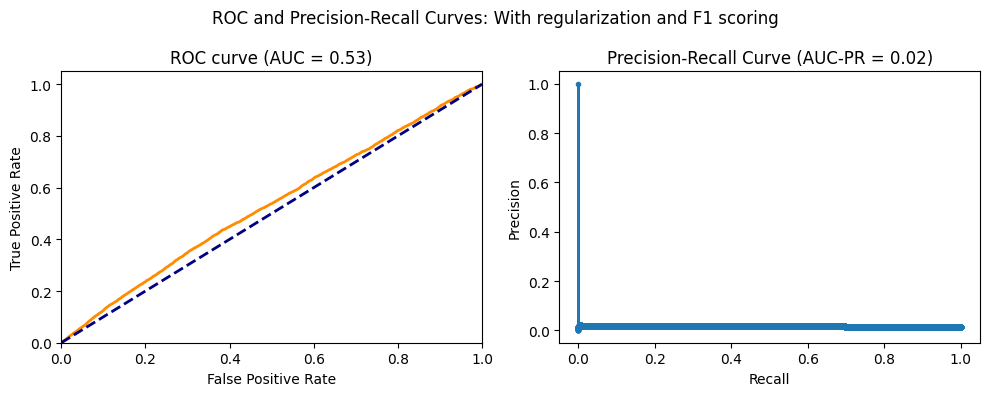

[[1394040       0]
 [  21434       0]]


In [397]:
#Linear regression model with Reguarization and F1 scoring

param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced']
}

log_model = LogisticRegression()

scorer = metrics.make_scorer(metrics.f1_score)

grid_search_f1 = GridSearchCV(log_model, param_grid, cv=5, scoring=scorer, n_jobs=-1).fit(train_data_x, train_data_y)

print(grid_search_f1.best_estimator_)

y_train_pred_f1 = grid_search_f1.predict(train_data_x)
y_train_prob_f1 = grid_search_f1.predict_proba(train_data_x)[:,1]

draw_roc_prc(train_data_y, y_train_prob_f1,"With regularization and F1 scoring")
print(metrics.confusion_matrix(train_data_y,y_train_pred_f1))



In [398]:
threshold_f1 = best_threshold(train_data_y, y_train_prob_f1)

Best Threshold: 0.49994339123985077


### Validation Comparison

In [399]:
val_data_y.value_counts()

outcome
0    399179
1      5949
Name: count, dtype: int64

In [400]:
grid_search_base_val_pred = (log_model_base.predict_proba(val_data_x)[:,1] >= threshold_base).astype(int)
grid_search_l2_val_pred = (grid_search_l2.predict_proba(val_data_x)[:,1] >= threshold_l2).astype(int)
grid_search_f1_val_pred = (grid_search_f1.predict_proba(val_data_x)[:,1] >= threshold_f1).astype(int)
grid_search_balanced_val_pred = (grid_search_balanced.predict_proba(val_data_x)[:,1] >= threshold_balanced).astype(int)

In [401]:

print(metrics.confusion_matrix(val_data_y,grid_search_base_val_pred))
print(metrics.confusion_matrix(val_data_y,grid_search_l2_val_pred))
print(metrics.confusion_matrix(val_data_y,grid_search_f1_val_pred))
print(metrics.confusion_matrix(val_data_y,grid_search_balanced_val_pred))

[[397965   1214]
 [  5931     18]]
[[397965   1214]
 [  5931     18]]
[[397965   1214]
 [  5931     18]]
[[396069   3110]
 [  5887     62]]


In [402]:

print(metrics.f1_score(val_data_y, grid_search_base_val_pred))
print(metrics.f1_score(val_data_y,grid_search_l2_val_pred))
print(metrics.f1_score(val_data_y,grid_search_f1_val_pred))
print(metrics.f1_score(val_data_y,grid_search_balanced_val_pred))

0.005013229355243003
0.005013229355243003
0.005013229355243003
0.013595000548185505


In [403]:
print(metrics.accuracy_score(grid_search_base_val_pred,val_data_y))
print(metrics.accuracy_score(grid_search_l2_val_pred,val_data_y))
print(metrics.accuracy_score(val_data_y,grid_search_f1_val_pred))
print(metrics.accuracy_score(grid_search_balanced_val_pred,val_data_y))

0.9823635986651132
0.9823635986651132
0.9823635986651132
0.9777922039454198


### Test Comparison

All three logistic regression models performed the same, therefore I decided to choose one of them.

In [404]:
grid_search_f1_test_pred = (grid_search_f1.predict_proba(test_data_x)[:,1] >= threshold_f1).astype(int)
print(metrics.accuracy_score(test_data_y, grid_search_f1_test_pred))

0.9787945546510709


In [405]:

print(metrics.confusion_matrix(test_data_y, grid_search_f1_test_pred))

[[198131   1221]
 [  3072     24]]
